Something that has long bothered me a little bit is the practice of training binary classification models by minimizing negative log-likelihood (a.k.a. log-loss) but then assessing the model by looking at its AUC. I'm aware of various reasons why this happens, but I suspect one that is often overlooked is the fact that AUC has a simple, intuitive interpretation and a consistent scale.

Specifically, AUC is (an estimate of) [the probability that the model will correctly distinguish a random postive example from a random negative example](https://nbviewer.org/github/drpeteb/pope/blob/master/pairwise-ordering-propability-estimates.ipynb). As a probability, it always lies in the $[0.0,1.0]$ interval. Moreover, we can reference against the trivial baseline where we select at random, giving an AUC of $0.5$. So the space of _meaningful_ values is really just $[0.5, 1.0]$. This range is the same for any bianry classification, so it is possible to build up some intuition about how "good" different values are (at least within some domain), which is useful in model development.

The same properties do not hold for log-loss. It is lower bounded at $0.0$ but has no upper bound, and two different models can have wildly different values.

This notebook explores the log-loss landscape, and aims to develop some intuition around it and provide some mental scaffolding for interpreting its values. (Um, apologies for the mixed metaphors.)

# Model

Here's a probabilistic classification model.

$x \in \mathcal{X}$ is a feature vector

$y \in \{0, 1\}$ is a binary label

Our objective is infer $y$ from $x$ for unseen samples. We train a model $f: \mathcal{X} \rightarrow [0,1]$ which outputs an estimate of the probability of $y$ being $1$.

We train our model on a data set of $N$ samples $x^{(n)}, y^{(n)} \sim p(x, y)$, with a base rate or "mean label" of $\varpi = p(y) = \int p(x, y) dx$.

For each sample $\pi^{(n)} = f(x^{(n)})$.

The empirical negative log likelihood (or log-loss) is

$\mathcal{L} = - \frac{1}{N} \sum_n \left[ y^{(n)} \log(\pi^{(n)}) + (1 - y^{(n)}) \log(1 - \pi^{(n)}) \right]$

# Import!

In [1]:
from dataclasses import dataclass
import numpy as np
from scipy import stats, optimize, special
import matplotlib.pyplot as plt
import seaborn as sns

# Thingumies

We're going to need this in a bit...

In [2]:
# Surely this should be in scipy somewhere!?
def binary_entropy(p):
  p = np.asarray(p)
  ent = np.zeros(p.shape)
  mask = (p > 0.0) & (p < 1.0)
  ent[(p < 0) | (p > 1)] = np.nan
  ent[(p == 0) | (p == 1)] = 0.0
  ent[mask] = -p[mask] * np.log(p[mask]) - (1 - p[mask]) * np.log(1 - p[mask])
  return ent

# The Issue

Let's take a look at some log-loss values for some real models.

In [3]:
@dataclass(frozen=True)
class ModelStats:
    name: str
    mean_label: float
    log_loss: float

model_stats = [
  ModelStats('Model A',     0.11,  0.24),
  ModelStats('Model B', 0.023, 0.093),
  ModelStats('Model C',     0.58,  0.60),
]

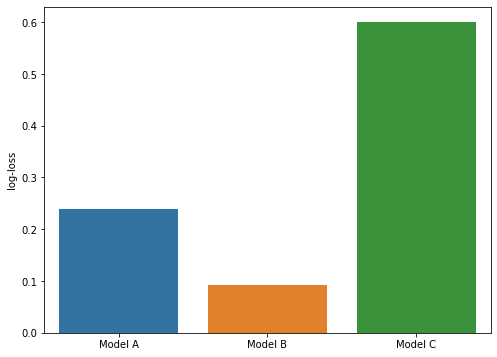

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(ax=ax, x=[m.name for m in model_stats], y=[m.log_loss for m in model_stats])
ax.set_ylabel('log-loss')
plt.show()

What does this mean? Is the Model B model somehow "better" than Model A? Does Model C suck? We need more context to interpret these numbers.

# Upper Bound

With AUC, we always think about values referenced against the trivial baseline model which selects at random between each positive/negative pair, giving an AUC of $0.5$. What is the equivalent of this baseline for log-loss?

Unlike AUC which only depends on ranking, log-loss is a function of the probability assigned by the model to each example, so we need to think about the baseline model a bit differently. The simplest probability model is one which just assigns a fixed probability $\pi$ to every example, ignoring all the features. This gives us a log-loss of

$\mathcal{L} = - \frac{1}{N} \sum_n \left[ y^{(n)} \log(\pi) + (1 - y^{(n)}) \log(1 - \pi) \right]$

Taking the expectation over datasets,

$
\begin{align}
\mathbb{E}[\mathcal{L}] &= - \frac{1}{N} \sum_n \left[ \mathbb{E}[y^{(n)}] \log(\pi) + \mathbb{E}[(1 - y^{(n)})] \log(1 - \pi) \right] \\
&= - \left[ \varpi \log(\pi) + (1-\varpi) \log(1 - \pi) \right]
\end{align}
$

We can minimize this with respect to $\pi$.

$
\frac{\partial\mathbb{E}[\mathcal{L}]}{\partial\pi} = -\left[ \frac{\varpi}{\pi} - \frac{1-\varpi}{1-\pi} \right]
$

$
\frac{\partial\mathbb{E}[\mathcal{L}]}{\partial\pi} = 0 \Rightarrow \pi = \varpi
$

So the best option is to use the label base rate as the prediction for every example, and the expected log-loss associated with doing this is

$
\begin{align}
\mathbb{E}[\mathcal{L}] &= - \left[ \varpi \log(\varpi) + (1-\varpi) \log(1 - \varpi) \right] \\
&= H(\varpi)
\end{align}
$

where $H(\cdot)$ is the binary entropy function.

This means that appropriate reference log-loss depends on the label base rate, and we need to take this into account when interpreting. It is easier to attain a smaller log-loss on a highly imbalanced dataset - it's probably the majority class!

# Lower Bound

The lower bound for log-loss is 0. It's worth spending a moment to think about what this values means and how it can be achieved. For an individual example with $y^{(n)} = 1$ the contribution to the log-loss is $\log(\pi)$, which is $0$ if $\pi^{(n)}=1$. Similarly for $y^{(n)}=0$, $\pi^{(n)}=0$. So to achieve $\mathcal{L} = 0$ we need the model to make a certain prediction about every example and for it to be correct. This is a very strong condition, which will be extremely hard to achieve in practice, so we should not expect to ever get particularly close to $0$.

# With Context

Let's replot our three real models to take this mean-label context into account.

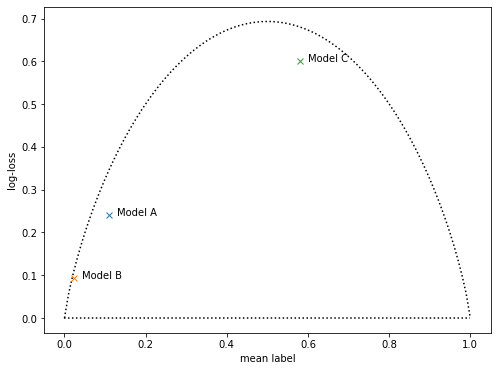

In [5]:
p_range = np.linspace(0, 1, 101)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(p_range, binary_entropy(p_range), ':k')
ax.plot(p_range, np.zeros(p_range.shape), ':k')
for m in model_stats:
  ax.plot(m.mean_label, m.log_loss, 'x')
  ax.text(m.mean_label+0.02, m.log_loss, f'{m.name}')
ax.set_xlabel('mean label')
ax.set_ylabel('log-loss')
plt.show()

Aha! This makes things much clearer. All three models are a bit better than the baseline log-loss attained by the constant-prediction model.

This still leaves us with some open questions. Are these values "good" in some absolute sense? Can we make any meaningful conparison between them? We need some way to better understand what different log-loss values actually mean.

# Yardsticks

One way to do this is to use a simple generative model as a yardstick. Suppose we have a distribution which generates predictions, and label values drawn according to these predictions. We can compute the (expected) log-loss for such a model.

If we have a sufficiently expressive family of distributions, then we can set parameters so as to achieve any combination of mean label and log-loss. We can then make a comparison between any two points in mean-label,log-loss space by comparing the parameters of the associated yardstick model. We can also visualize this yardstick prediction distribution to get a feel for what sort of predictions such a model might produce.

The expected log-loss for a generative model like this is

$
\begin{align}
\mathbb{E}[\mathcal{L}] &= - \frac{1}{N} \sum_n \mathbb{E}\left[ y^{(n)} \log(\pi) + (1 - y^{(n)}) \log(1 - \pi) \right] & \text{definition}\\
&= - \frac{1}{N} \sum_n \mathbb{E}_{\pi} \left[ \mathbb{E}_y[y^{(n)} | \pi^{(n)}] \log(\pi^{(n)}) + \mathbb{E}_y[(1 - y^{(n)}) | \pi^{(n)}] \log(1 - \pi^{(n)}) \right]  & \text{conditional expectation} \\
&= - \frac{1}{N} \sum_n  \mathbb{E}_{\pi} \left[ \pi^{(n)} \log(\pi^{(n)}) + (1-\pi^{(n)}) \log(1 - \pi^{(n)}) \right]  & \text{expectation of label}\\
&= \frac{1}{N} \sum_n  \mathbb{E}_{\pi} \left[ H(\pi^{(n)}) \right]  & \text{binary entropy definition} \\
&= \mathbb{E}_{\pi} \left[ H(\pi) \right]  & \text{i.i.d. examples} \\
\end{align}
$



# Logit-Normal

The [logit-normal](https://en.wikipedia.org/wiki/Logit-normal_distribution) distribution family is ideal for our purposes here. It's the distribution we get if we draw a normal variate and then stick it through the logit function to squish it into $[0,1]$.

Logit-normal distributions are parameterised by the mean and standard deviation of the underlying normal random variable. When the standard deviation is low, the predictions are tightly grouped around a single value, just like our fixed-prediction reference model. When the standard deviation is high, the predictions cluster into two peaks around 0 and 1, indicating high confidence. Assuming these predictions are also correct, this is just like the perfect model with zero log-loss. So the family spans the range of possible log-loss values.

It's also worth noting that this is exactly the distribution of predictions we would get from a linear model with normally-distributed input features.

In [6]:
def logit_normal_pdf(x, mu, sigma):
  if x <= 0 or x >= 1:
    return 0.0
  logitx = special.logit(x)
  constant_bit = 1 / (np.sqrt(2 * np.pi) * sigma)
  polynomial_bit = 1 / (x * (1 - x))
  exponential_bit = np.exp(-(logitx - mu)**2/(2 * sigma**2))
  return constant_bit * polynomial_bit * exponential_bit

def logit_normal_rvs(mu, sigma, size):
  x = stats.norm.rvs(mu, sigma, size)
  return special.expit(x)

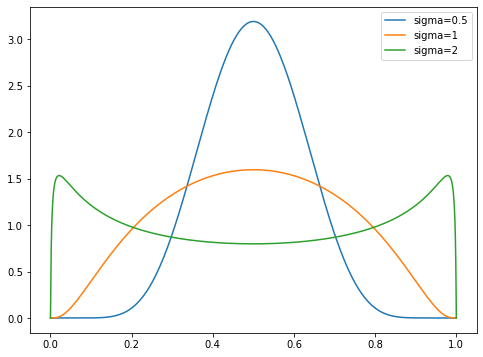

In [7]:
p_range = np.linspace(0, 1, 10001)

fig, ax = plt.subplots(figsize=(8,6))
for sigma in [0.5, 1, 2]:
  ax.plot(p_range, [logit_normal_pdf(p, 0, sigma) for p in p_range], label=f'sigma={sigma}')
ax.legend()
plt.show()

So here's what we'll do. Let's say there's a model we're interested with specific mean-label and log-loss. We'll find $\mu$ and $\sigma$, the parameters of a logit-normal generative model, to match these values. The $\sigma$ value then tells us something about how "good" the model is. (The $\mu$ value will just be used to make sure the mean-label is correct.)

The tricky thing about logit-normal distributions is that taking any sort of expectation is impossible analytically, because of that ugly PDF. We cannot even evaluate the mean analytically, let alone the expectation of the binary entropy function. However, it is simple to use numerical methods.

In [8]:
def make_mean_logloss_cost(target_mean, target_log_loss, u):
  def cost(x):
    p = special.expit(x[0] + x[1] * u)
    est_mean = np.mean(p)
    est_log_loss = np.mean(binary_entropy(p))
    return (target_mean - est_mean)**2 + (target_log_loss - est_log_loss)**2
  return cost

def find_logit_normal_params(target_mean, target_log_loss, N=10000):
  u = np.random.default_rng().standard_normal(size=(N,))
  result = optimize.minimize(make_mean_logloss_cost(target_mean, target_log_loss, u), np.asarray((0, 1)))
  (mu, sigma) = result.x
  return (mu, sigma)

Model: Model A
Mean: 0.11 (actual) | 0.107 (fitted)
Expected log-loss: 0.24 (actual) | 0.239 (fitted)
(Log-loss bound: 0.347)
mu=-3.156, sigma=1.880


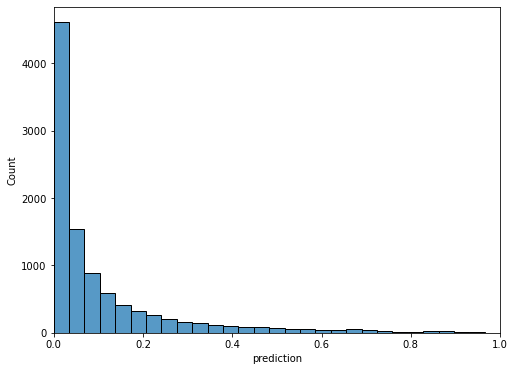

Model: Model B
Mean: 0.023 (actual) | 0.022 (fitted)
Expected log-loss: 0.093 (actual) | 0.092 (fitted)
(Log-loss bound: 0.109)
mu=-4.462, sigma=1.241


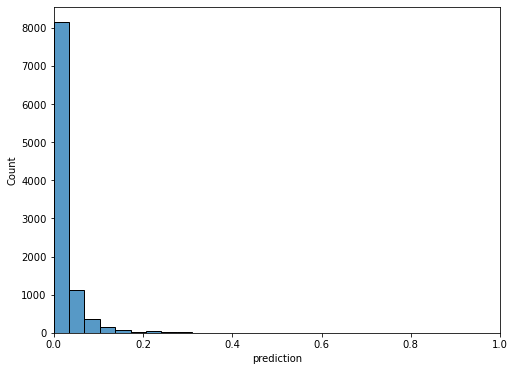

Model: Model C
Mean: 0.58 (actual) | 0.580 (fitted)
Expected log-loss: 0.6 (actual) | 0.602 (fitted)
(Log-loss bound: 0.680)
mu=0.374, sigma=0.910


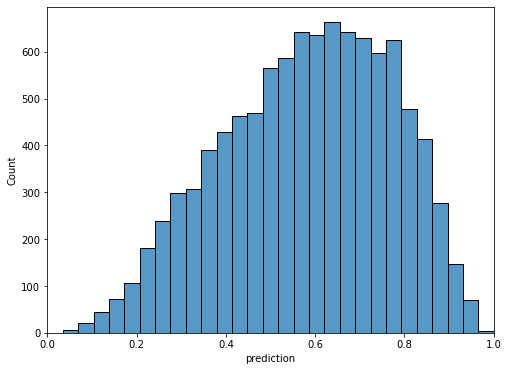

In [9]:
N = 10000

for model in model_stats:
  mu, sigma = find_logit_normal_params(model.mean_label, model.log_loss, N=N)
  print(f'Model: {model.name}')
  print(f'Mean: {model.mean_label} (actual) | {np.mean(logit_normal_rvs(mu, sigma, N)):.3f} (fitted)')
  print(f'Expected log-loss: {model.log_loss} (actual) | {np.mean(binary_entropy(logit_normal_rvs(mu, sigma, 10000))):.3f} (fitted)')
  print(f'(Log-loss bound: {binary_entropy(model.mean_label):.3f})')
  print(f'mu={mu:.3f}, sigma={sigma:.3f}')

  fig, ax = plt.subplots(figsize=(8,6))
  sns.histplot(logit_normal_rvs(mu, sigma, N), bins=np.linspace(0, 1, 30), ax=ax)
  ax.set_xlim((0,1))
  ax.set_xlabel('prediction')
  plt.show()

What this tells us is that Model A is the best of the three, as its equivalent generative logit-normal distribution has the highest $\sigma$ value, followed by Model B and with Model C coming in third place. Moreover, we can say that Model A is more than twice as good as Model C.

We can also try sweeping a grid of logit normal parameters, in order to draw some contours of constant $\sigma$ on our mean-label,log-loss space.

In [14]:
def make_mean_cost(target_mean, normal_scale, u):
  def cost(x):
    est_mean = np.mean(special.expit(x + normal_scale * u))
    return (target_mean - est_mean)**2
  return cost

def make_sigma_contours():
  mean_range = np.linspace(0.01, 0.99, 99)
  sigma_range = np.sqrt(10.0)**np.arange(-2, 5)
  N = 10000
  u = np.random.default_rng().standard_normal(size=(N,))

  ll_range = np.zeros((len(mean_range), len(sigma_range)))
  mu_range = np.zeros((len(mean_range), len(sigma_range)))

  for ii, mean in enumerate(mean_range):
    for jj, sigma in enumerate(sigma_range):
      result = optimize.minimize_scalar(make_mean_cost(mean, sigma, u))
      mu = result.x
      mu_range[ii, jj] = mu
      ll_range[ii, jj] = np.mean(binary_entropy(logit_normal_rvs(mu, sigma, N)))
  
  return mean_range, sigma_range, ll_range

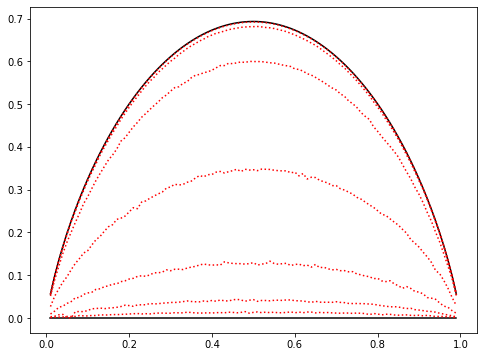

In [15]:
mean_range, sigma_range, ll_range = make_sigma_contours()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(mean_range, binary_entropy(mean_range), 'k')
ax.plot(mean_range, np.zeros(mean_range.shape), 'k')
for jj, sigma in enumerate(sigma_range):
  ax.plot(mean_range, ll_range[:, jj], ':r')
plt.show()

Those contours kinda look like constant proportions of the binary entropy function. Let's check how close they are...

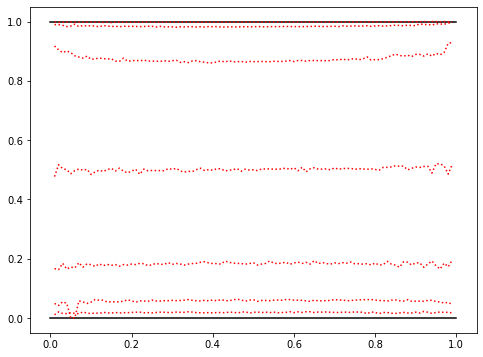

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot((0,1), (1,1), 'k')
ax.plot((0,1), (0,0), 'k')
for jj, sigma in enumerate(sigma_range):
  ax.plot(mean_range, ll_range[:, jj]/binary_entropy(mean_range), ':r')
plt.show()

Pretty close. So a simpler and largely equivalent way to compare models is just to compute the ratio of their log-loss to that of the reference model for the same mean-label, i.e. the binary entropy function.

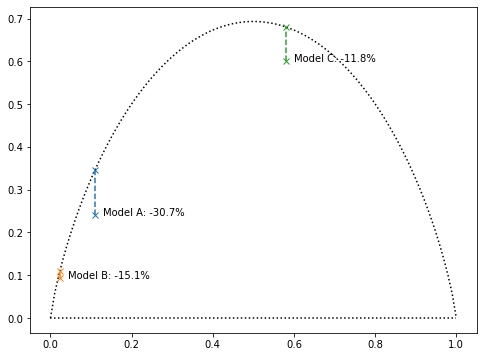

In [17]:
p_range = np.linspace(0, 1, 101)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(p_range, binary_entropy(p_range), ':k')
ax.plot(p_range, np.zeros(p_range.shape), ':k')
for m in model_stats:
  lim = binary_entropy(m.mean_label)
  reduction = (lim - m.log_loss) / lim
  ax.plot(m.mean_label*np.ones(2), (m.log_loss, lim), 'x--')
  ax.text(m.mean_label+0.02, m.log_loss, f'{m.name}: -{reduction:.1%}')
plt.show()

As before this shows Model A to be the best, followed by Model B and Model C.

Finally, we can select some parameters to obtain a better log-loss that one of our models, and get an idea of what the prediction distribution would need to look like. Let's do this with Model C. What would happen if we reduced the log-loss to 0.5? or 0.4? of 0.3?

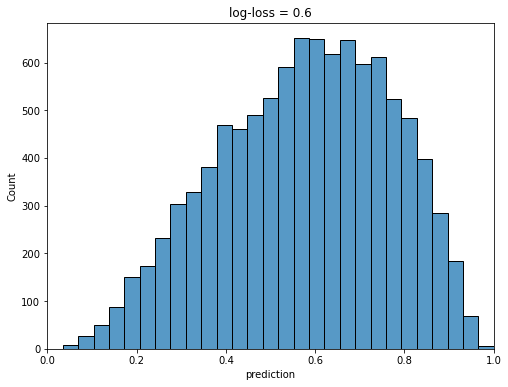

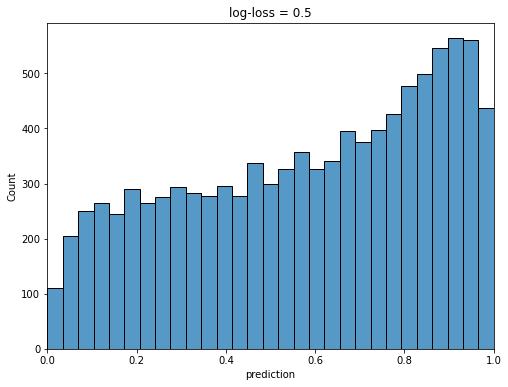

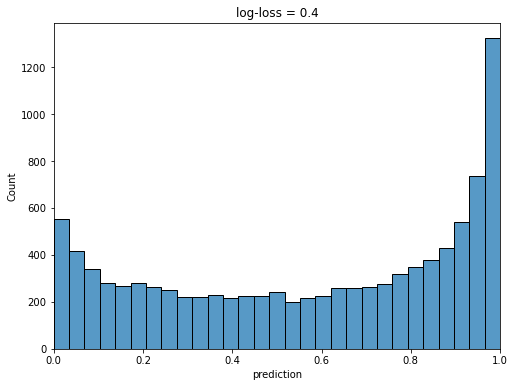

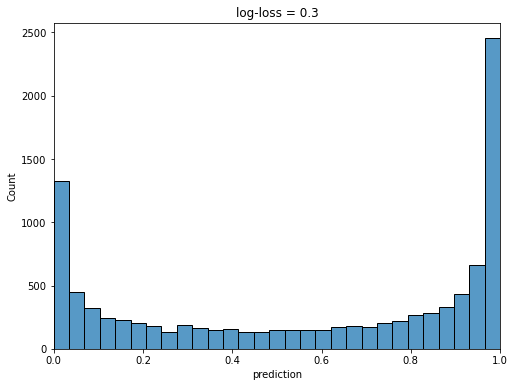

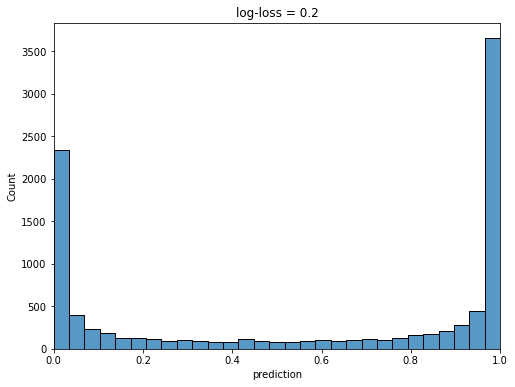

In [18]:
model = model_stats[2]
for log_loss in [0.6, 0.5, 0.4, 0.3, 0.2]:
  mu, sigma = find_logit_normal_params(model.mean_label, log_loss, N=N)
  fig, ax = plt.subplots(figsize=(8,6))
  sns.histplot(logit_normal_rvs(mu, sigma, N), bins=np.linspace(0, 1, 30), ax=ax)
  ax.set_xlim((0,1))
  ax.set_xlabel('prediction')
  ax.set_title(f'log-loss = {log_loss}')
  plt.show()

So at 0.6 (the true value) it is a lump in the middle. At 0.5 it fills out the extremes. At 0.4 it splits into two peaks around 0 and 1. and Below this is just puts more and more of the probability mass at the ends.